In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile, os

ZIP_PATH = "/content/drive/MyDrive/paddy-disease-classification.zip"
DATA_DIR = "/content/paddy_dataset"

if os.path.exists(DATA_DIR):
    !rm -rf /content/paddy_dataset

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

print(os.listdir(DATA_DIR))


['test_images', 'train.csv', 'train_images', 'sample_submission.csv']


In [ ]:
TRAIN_DIR = os.path.join(DATA_DIR, "train_images")
print(os.listdir(TRAIN_DIR))


['bacterial_leaf_blight', 'brown_spot', 'normal', 'downy_mildew', 'blast', 'hispa', 'dead_heart', 'bacterial_panicle_blight', 'tungro', 'bacterial_leaf_streak']


In [ ]:
TRAIN_DIR = os.path.join(DATA_DIR, "train_images")
print(os.listdir(TRAIN_DIR))


['bacterial_leaf_blight', 'brown_spot', 'normal', 'downy_mildew', 'blast', 'hispa', 'dead_heart', 'bacterial_panicle_blight', 'tungro', 'bacterial_leaf_streak']


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

val_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [ ]:
train_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_data = val_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [ ]:
class_names = list(train_data.class_indices.keys())
print(class_names)


['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [ ]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # stage 1


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)

outputs = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=3)
]


In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 198s 645ms/step - accuracy: 0.1598 - loss: 2.2135 - val_accuracy: 0.1671 - val_loss: 2.1644 - learning_rate: 1.0000e-04
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 135s 518ms/step - accuracy: 0.1564 - loss: 2.1865 - val_accuracy: 0.1671 - val_loss: 2.1629 - learning_rate: 1.0000e-04
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 130s 500ms/step - accuracy: 0.1663 - loss: 2.1777 - val_accuracy: 0.1671 - val_loss: 2.1647 - learning_rate: 1.0000e-04
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 130s 497ms/step - accuracy: 0.1731 - loss: 2.1649 - val_accuracy: 0.1671 - val_loss: 2.1616 - learning_rate: 1.0000e-04
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 130s 498ms/step - accuracy: 0.1606 - loss: 2.1694 - val_accuracy: 0.1695 - val_loss: 2.1654 - learning_rate: 1.0000e-04
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 133s 510ms/step - accuracy: 0.1590 - loss: 2.1744 - val_accuracy: 0.1671 - val_loss: 2.1630 - learning_rate: 1.0000e-04
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# 🔴 Put a real image name from test_images
TEST_IMAGE_PATH = "/content/paddy_dataset/test_images/200467.jpg"

img = image.load_img(TEST_IMAGE_PATH, target_size=(224, 224))
img = image.img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
idx = np.argmax(pred)

print("✅ Predicted Disease:", class_names[idx])
print("✅ Confidence:", round(float(pred[0][idx]) * 100, 2), "%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
✅ Predicted Disease: blast
✅ Confidence: 16.02 %


In [ ]:
import os

TEST_DIR = "/content/paddy_dataset/test_images"
os.listdir(TEST_DIR)[:10]


['200467.jpg',
 '203440.jpg',
 '201022.jpg',
 '202280.jpg',
 '203271.jpg',
 '201853.jpg',
 '201571.jpg',
 '201754.jpg',
 '201144.jpg',
 '201875.jpg']

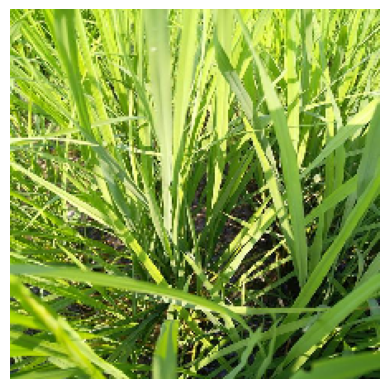

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img[0])
plt.axis("off")
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/paddy_disease_model.h5")
print(" Model saved to Google Drive")


 Model saved to Google Drive


In [ ]:
import json

with open("/content/drive/MyDrive/paddy_classes.json", "w") as f:
    json.dump(class_names, f)

print("Class names saved")


Class names saved


In [ ]:
from google.colab import files

files.download("/content/drive/MyDrive/paddy_disease_model.h5")
files.download("/content/drive/MyDrive/paddy_classes.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving example3.jpeg to example3.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
🌾 Predicted Disease: blast
🎯 Confidence: 15.9 %


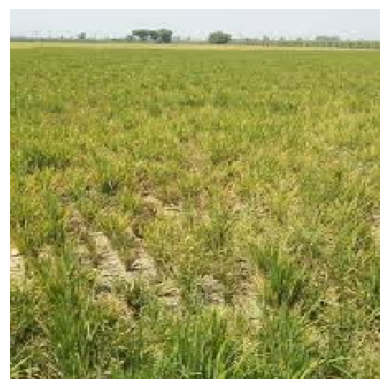

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

IMAGE_PATH = "/content/example3.jpeg"   # ✅ correct

img = image.load_img(IMAGE_PATH, target_size=(224, 224))
img_arr = image.img_to_array(img) / 255.0
img_arr = np.expand_dims(img_arr, axis=0)

pred = model.predict(img_arr)
idx = np.argmax(pred)

print("🌾 Predicted Disease:", class_names[idx])
print("🎯 Confidence:", round(float(pred[0][idx]) * 100, 2), "%")

plt.imshow(img)
plt.axis("off")
plt.show()
